In [1]:
import copy
import os
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim
from scipy.io import loadmat
import scipy
import pickle
import control as ct
import seaborn as sns
import pandas as pd

## Functions for running BOP-DMD training and testing

In [2]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    '''
    Function for computing BOP-DMD models of different trial sizes, number of modes, and with different optimization settings
    such as enforcing that eigenvalues come in complex conjugate pairs, or that the eigenvalues lie in the left half plane
    
    parameters:
    svd_rank: int. number of modes to be fit to given data set
    num_trials: int. number of models fit in each call of BOP-DMD
    training_set: array. training data
    training_voltage: array. inputs that accompany training data. Only used if return_training_fit = True
    test_voltage: array. voltage input waveform used to test learned BOP-DMD model
    train_time: 1d array. Time vector used for training data
    test_time: 1d array. time vector used for testing data
    Btilde: array. B matrix used in x_dot = Ax + Bu. Determines how actuation effects each state. of size num_inputs X states
    return_training_fit: bool. Returns the result of BOP-DMD on the training data
    conjugate_bool: bool. Determine if eigs come in complex conjugate pairs
    stable_bool: bool used to determine if eigs are forced to lie in left half plane
    noise_level: int. Can be used to add noise to training data. Mostly used when one wants to train on simulation data
    evaluate: bool. if true, returns the result of learned BOP-DMD model, paired with Btilde, C,D on test voltage
    C: array. C matrix to determine what ouputs are measured. y = Cx + Du. of size num_inputs X states
    D: array: Feedforeward matrix. Typically all zeros for these systems. of size states X num_inputs
    
    '''
    
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        # Decide if we want to enforce that the models have eigenvalues that come in complex conjugate pairs, and 
        # enforce stability
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    

    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

## Import BOP-DMD model for the flux circuits in vacuum, and import analytic state space model for flux circuits in plasma and in vacuum

In [3]:
filename = 'data/continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

print(np.shape(A))

A_plasma = loadmat('data/plasma_ss_A_matrix').get('A')

print(np.shape(A_plasma))

B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

bop_A_vacuum = loadmat('data/BOP_A_matrix.mat').get('matrix')

print(np.shape(bop_A_vacuum))

object successfully saved to data/continuous_vacuum_ss_model
(12, 12)
(13, 13)
(12, 12)


## Function to load in a vacuum shot

In [4]:
def load_shot(directory,flux,plasma): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
    '''
    This function takes a file path and looks for .mat files containing the data from the HIT-SIU circuits. The function will
    cycle through the directory and pick out these files, and return lists of the circuit data configured in a specific order.
    
    parameters:
    directory: string. file path to desired .mat files to be loaded in.
    flux: bool. Determine if shot being loaded needs to look for flux circuit or voltage circuit variable names
    plasma: bool. Determine if toroidal plasma current ('i_tor') should be included in the time series
    '''   
        
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []
    
    if flux == True:

        state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    
    else:
        state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']
    
    
    if plasma == True:
        state_order.append('i_tor')
        
        
    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time



In [5]:
def make_graph(data,title,legend,impulse,time): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot
    '''
    Function for making graphs of circuit data in a particular configuration and order
    data: list of arrays to be plotted on the graph
    title: string to be used as plot title
    legend: array of strings indicating each legend entry. 
    impulse: bool. Changes the x-axis scale if the data being plotted is the tail end of the shot
    time: array. Time vector used when plotting

    '''


    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if impulse == False:
        plt.xlim([0,4])


    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k','--g']
    alphas = [1,.65,1]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)
    


## Load in flux data from plasma shot 220816009

In [6]:
flux_trajectory_list,flux_inputs_list,flux_state_deriv_list,experiment_time = load_shot('data/plasma_shots/flux_data/220816009',flux = True,plasma = True)

print(np.shape(flux_trajectory_list[0]))

(2256, 13)


## Below is a simulation of what an analytic linear model of the flux circuits look like when a plasma is present. 

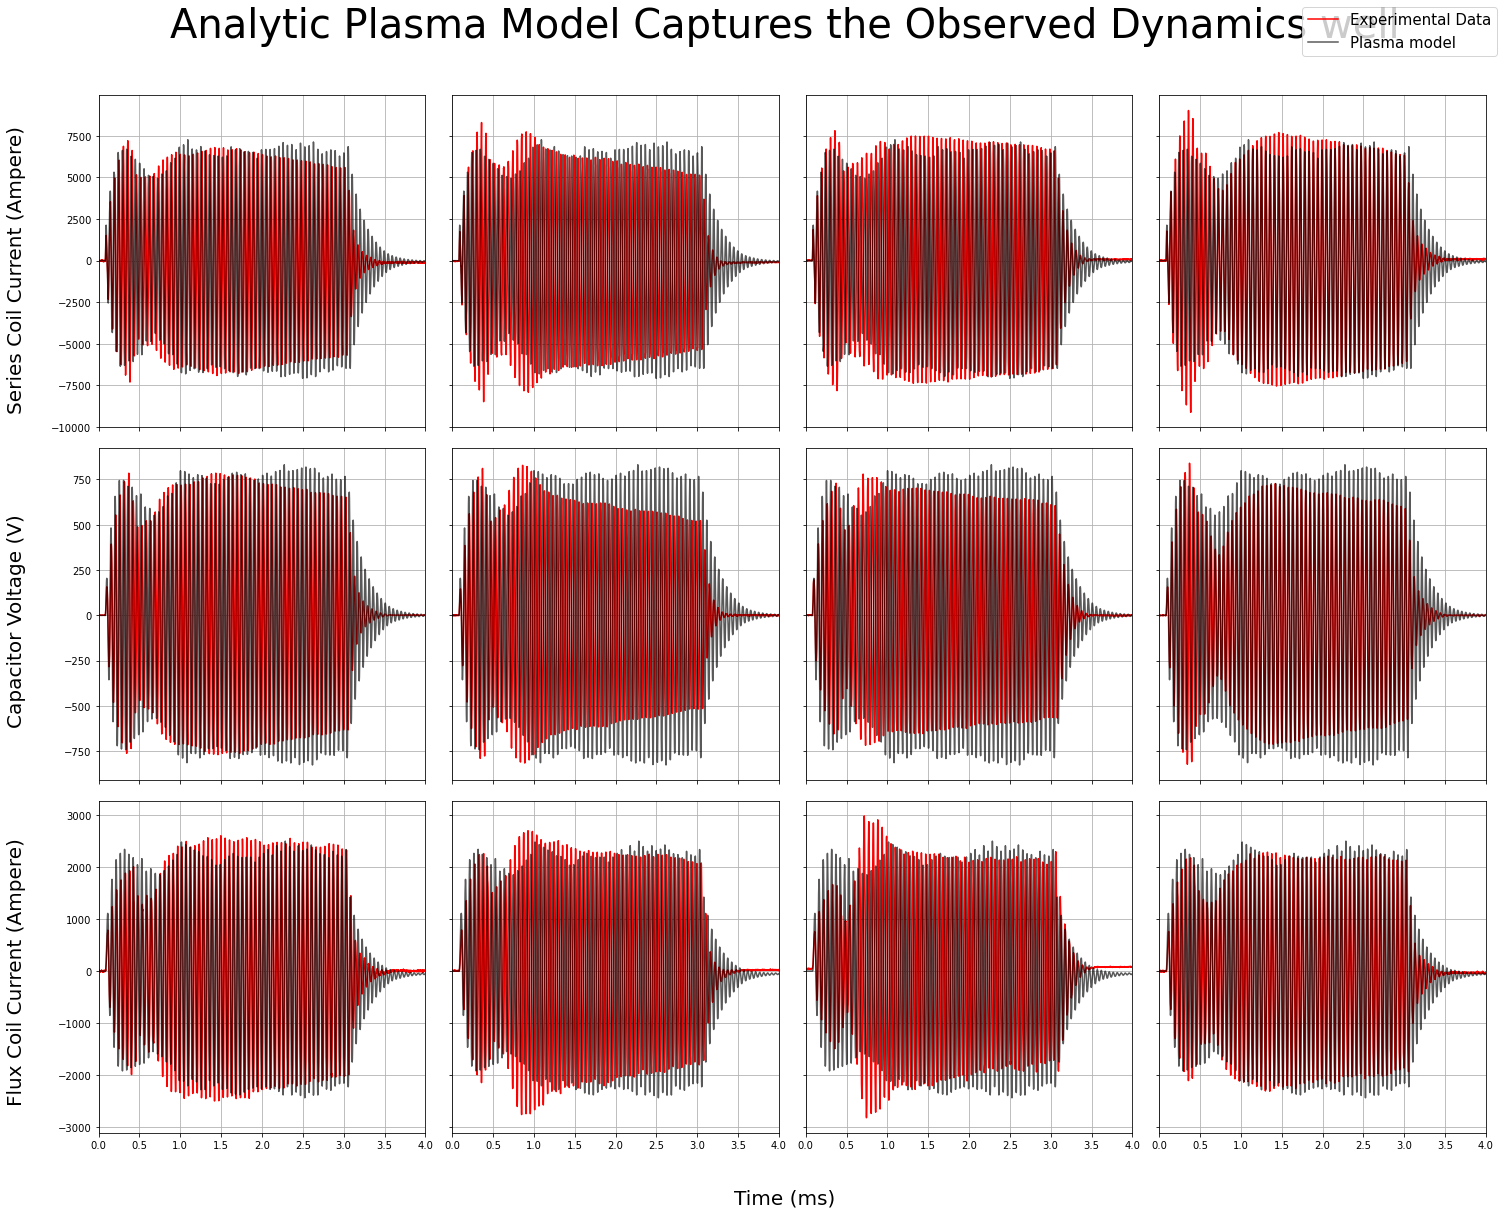

In [7]:
tout,yout,xout_plasma_ss = lsim((A_plasma,B_plasma,C_plasma,D),flux_inputs_list[0][251::,:],experiment_time[251::])

# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(xout_plasma_ss[:,i])
#     plt.plot(flux_trajectory_list[0][251::,i])
#     plt.legend(['Analytic Plasma model','Real plasma shot'])

make_graph([flux_trajectory_list[0][251::,:],xout_plasma_ss ], 'Analytic Plasma Model Captures the Observed Dynamics well',['Experimental Data','Plasma model'],
           impulse = False,time = experiment_time[251::] ) 

## Comparrison of BOP-DMD model from vacuum shot to a plasma shot

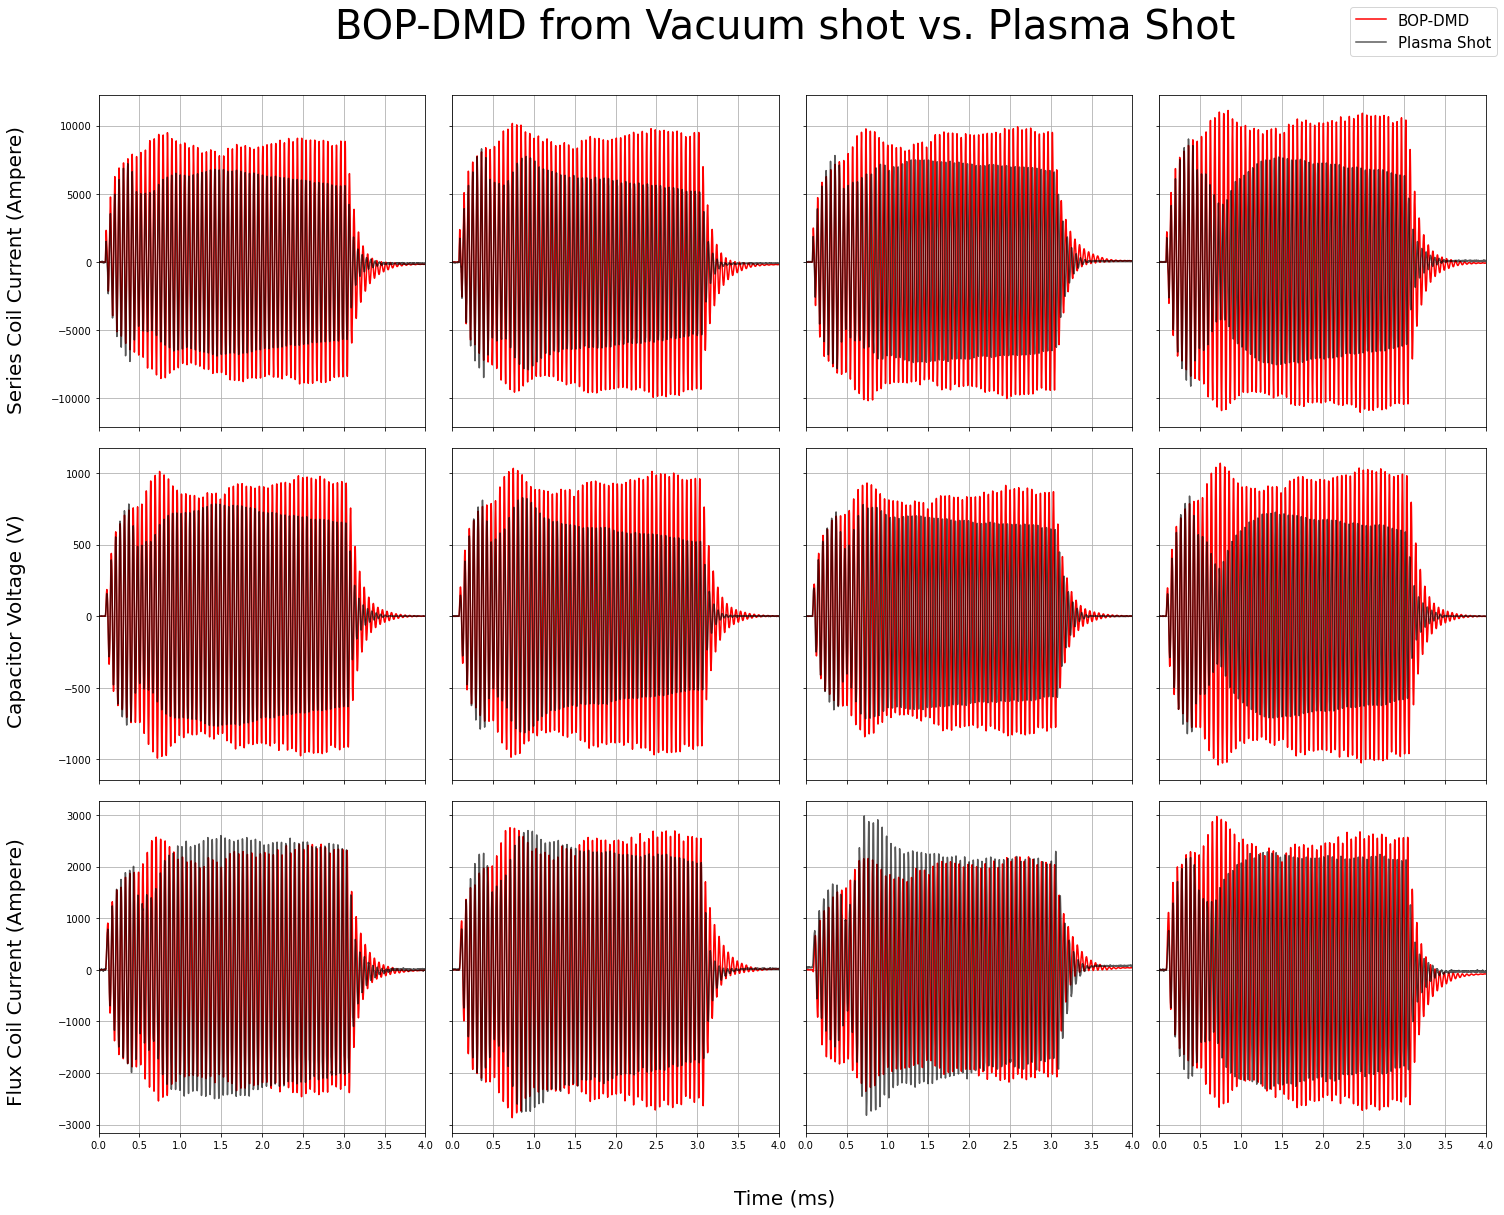

In [8]:
tout,yout,xout_vacuum_dmd = lsim((bop_A_vacuum,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])
make_graph([xout_vacuum_dmd,flux_trajectory_list[0][251::,:]],'BOP-DMD from Vacuum shot vs. Plasma Shot',['BOP-DMD','Plasma Shot'],
           impulse = False,time = experiment_time[251::])

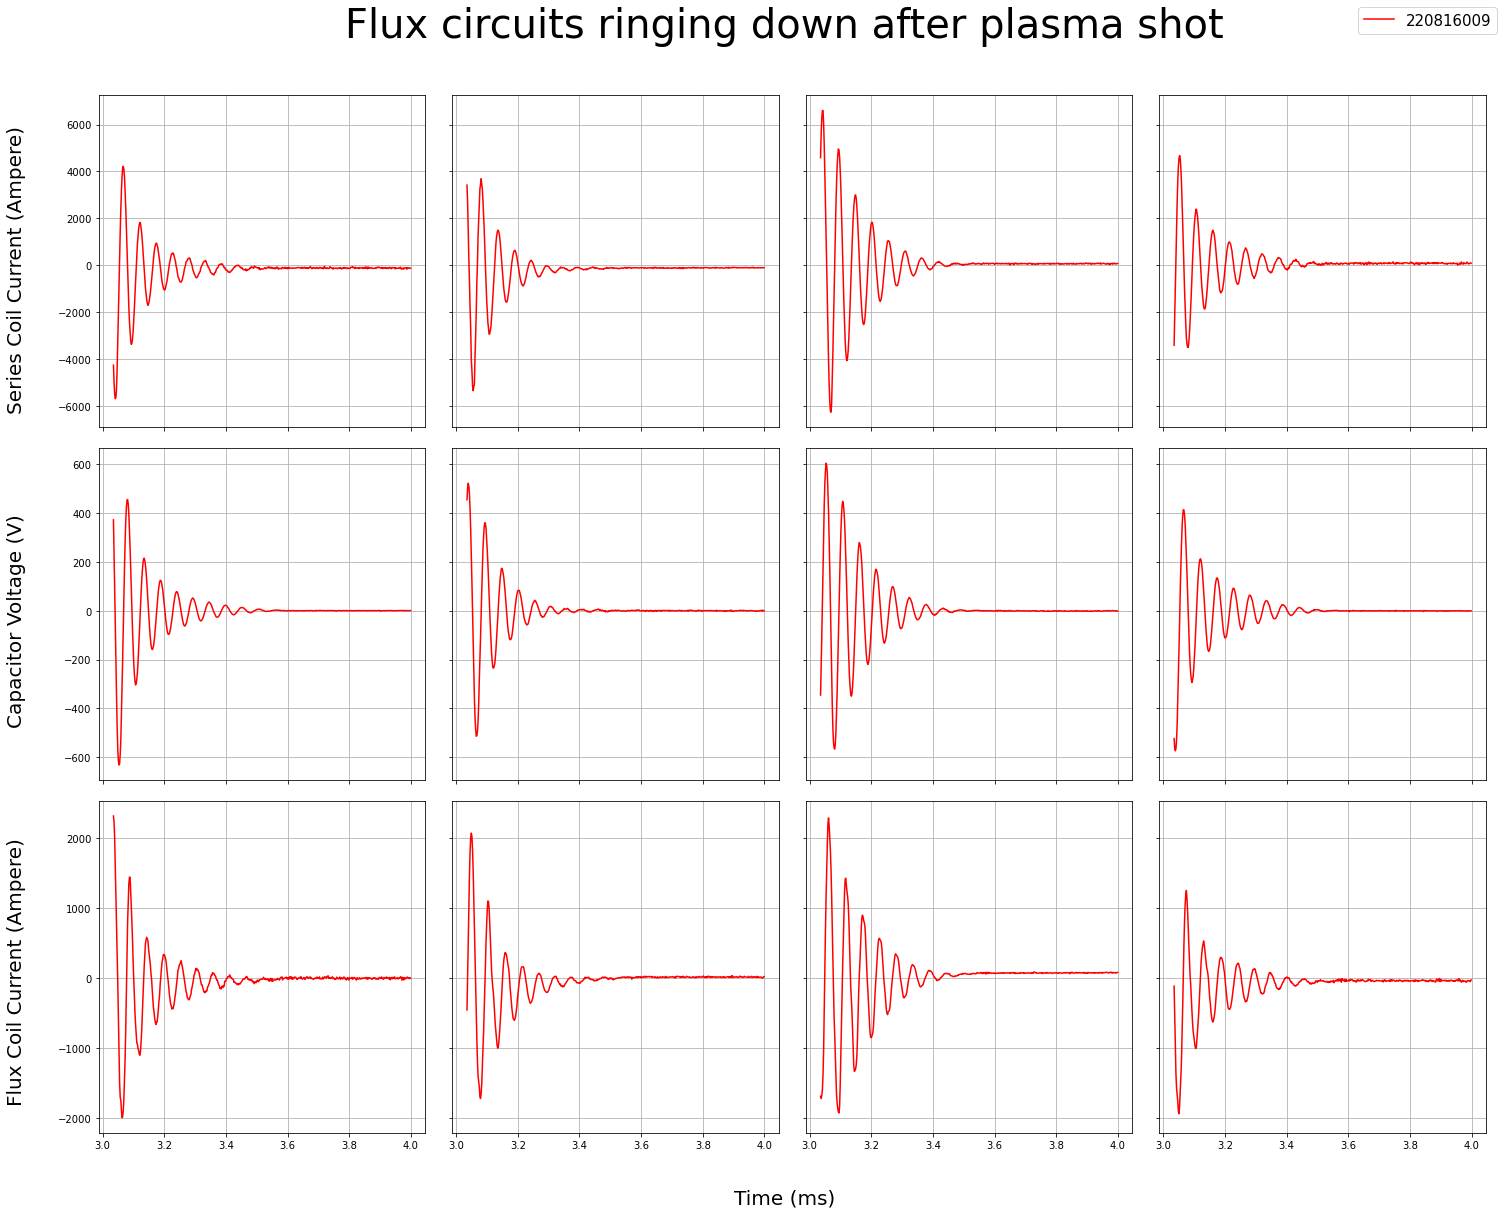

In [9]:

    
make_graph(data = [ flux_trajectory_list[0][1772::,:] ], title = 'Flux circuits ringing down after plasma shot',legend = ['220816009'],
                  impulse = True,time=experiment_time[1772::])

In [10]:


#Add on itor to the flux trajectory list
flux_trajectory_list[0] = np.hstack((flux_trajectory_list[0],voltage_trajectory_list[0][:,12].reshape(len(experiment_time),1)))



NameError: name 'voltage_trajectory_list' is not defined

## BOP on Flux circuits during a plasma shot. We train on just the ring down as it's when the effect of the power supplies is the least present

In [11]:
# We train BOP-DMD on the last ~480 samples of a shot, take the A matrix generated by BOP-DMD, stuff that into a 
# continuous time system, and simulate the system with the power supply waveforms that generated the shot. We then compare the 
#ground truth and the BOP-DMD prediction

Atilde_flux_list = []
bop_obj_flux_list = []
xout_flux_list = []
for i in range(30): #number of modes we want to fit.
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 30,
        training_set = flux_trajectory_list[0].T[0:13,1772::], 
        training_voltage = flux_inputs_list[0][1772::,:],
        test_voltage = flux_inputs_list[0][251::,:],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_flux_list.append(Atilde) #Each A matrix generated by BOP-DMD
    bop_obj_flux_list.append(bop_obj) # Each BOP-DMD object
    xout_flux_list.append(xout) #Test data for each fit. 


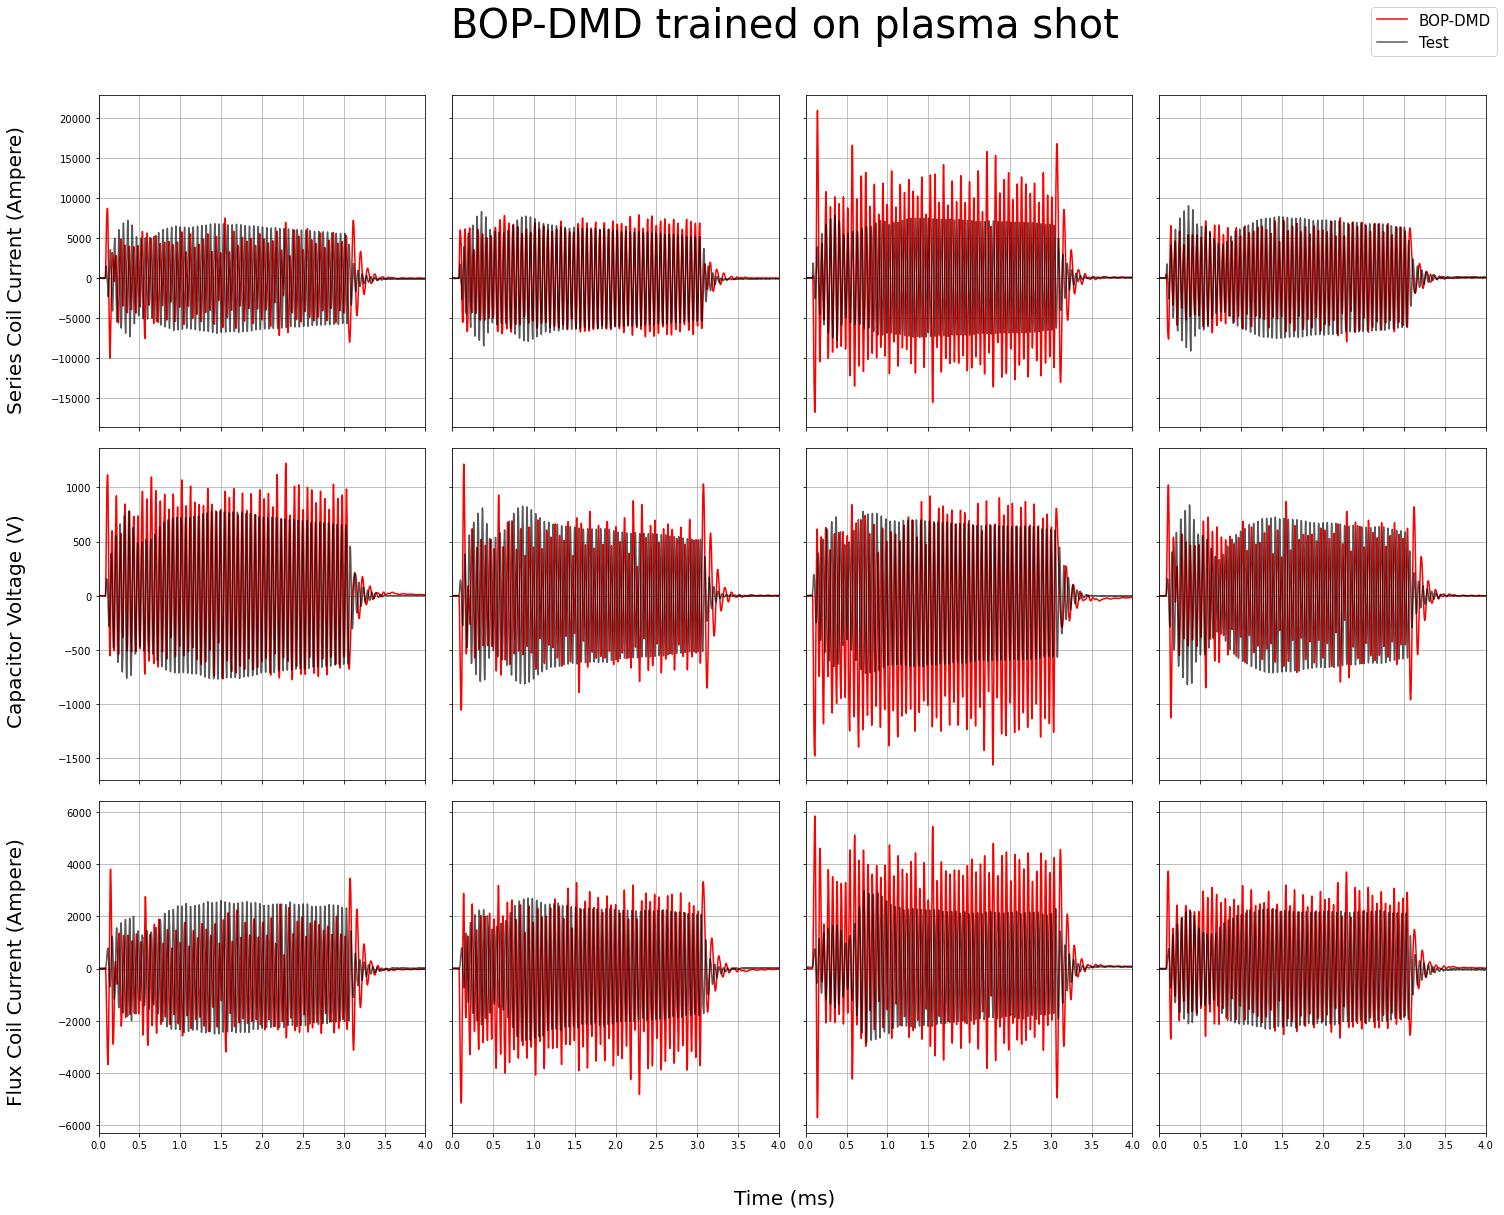

In [14]:
num = 4# number of modes that are included in the model. num = modes - 1
#3

#8


# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(np.real(xout_flux_list[num][::,i]))
#     plt.plot(flux_trajectory_list[0][251::,i])
#     plt.legend(['BOP','Test'])

make_graph([xout_flux_list[num].real,flux_trajectory_list[0][251::,:]],'BOP-DMD trained on plasma shot',['BOP-DMD','Test'],
           impulse = False,time = experiment_time[251::])

## Let's take a look at the eigenvalues for the DMD model vs. The Plasma model

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag)
#Eigenvalues on whatever number of modes is plotted above
plt.scatter(np.linalg.eigvals(Atilde_flux_list[num]).real,np.linalg.eigvals(Atilde_flux_list[num]).imag) 
plt.legend(['Analytic Plasma Eigs','BOP-DMD Eigs'])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.xlim(right = -100)
plt.grid()